# Houdini Neural Pressure Prediction
# -- Ingesting Data --
Load data from Houdini and save as collectivized NPZ array.

## Step 1) Visualize input data
Load example files and display content and difference

shape:  (144, 144) (144, 144) (145, 145)
shape:  (144, 144) (144, 144) (145, 145)


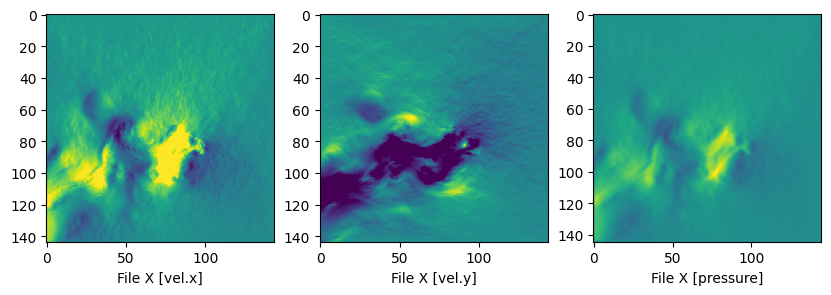

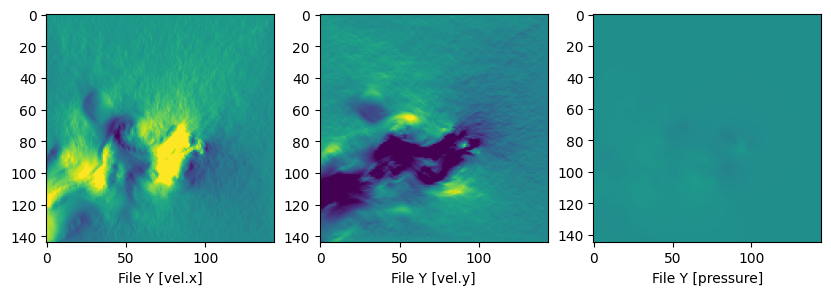

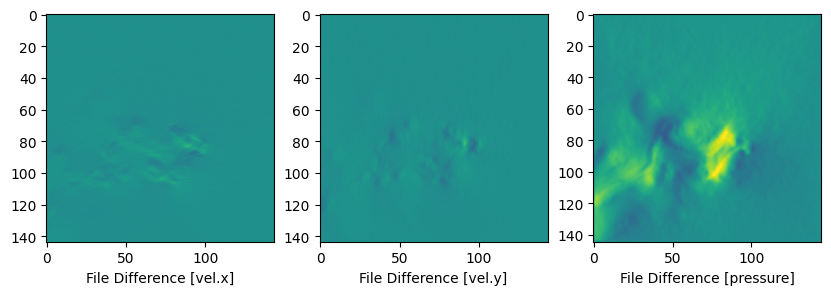

In [1]:
import numpy as np
import matplotlib.pyplot as plt

FIELDS = ["vel.x", "vel.y", "pressure"]

def plot_fields(fields, value_range=0.2, label=""):
    f = plt.figure( figsize=(10,100) )
    for idx, field in enumerate(fields):
        # Debug, plot figure
        f.add_subplot(1, 3, idx + 1)
        plt.xlabel(label + " [" + FIELDS[idx] + "]")
        plt.imshow(field, vmin=-value_range, vmax=value_range)
    plt.show(block=True)
    
def show_fields_diff(inputfile1, inputfile2, value_scale=1/20):
    with np.load(inputfile1) as data:
        velx = data['velx'][:,:,0] * value_scale
        vely = data['vely'][:,:,0] * value_scale
        pres = data['pres'][:,:,0] * value_scale
        print("shape: ", velx.shape, vely.shape, pres.shape)
    with np.load(inputfile2) as data:
        velx2 = data['velx'][:,:,0] * value_scale
        vely2 = data['vely'][:,:,0] * value_scale
        pres2 = data['pres'][:,:,0] * value_scale
        print("shape: ", velx2.shape, vely2.shape, pres2.shape)
    
    fields1 = [velx, vely, pres]
    fields2 = [velx2, vely2, pres2]
    fields_diff = [velx-velx2, vely-vely2, pres-pres2]

    plot_fields(fields1, label="File X")
    plot_fields(fields2, label="File Y")
    plot_fields(fields_diff, label="File Difference")
    

testfile = ("./data2D/hou_data/v4/npz_train/pyro1.w5.1200.pre_project.npz")
testfile2 = ("./data2D/hou_data/v4/npz_train/pyro1.w5.1200.post_project.npz")
show_fields_diff(testfile, testfile2)

## Step 2) Load Data as NP arrays

In [2]:
import os
import glob
import time
import numpy as np

def load_sim_files(file_list, verbose=False):
    """Loads simulation data from a list of files.

    Args:
        file_list: A list of file paths to load.
        verbose: Whether to print detailed timing information.

    Returns:
        A list of loaded data arrays.
    """

    start_time = time.perf_counter()
    data_array = []

    for idx, file_path in enumerate(file_list, 1):
        if verbose:
            print(f"Loading file {idx}/{len(file_list)}: {file_path}")

        try:
            with np.load(file_path) as data:
                velx = np.pad(data['velx'][:, :, 0], ((0, 1), (0, 1)))
                vely = np.pad(data['vely'][:, :, 0], ((0, 1), (0, 1)))
                pres = data['pres'][:, :, 0]

                # Scale the data
                fields = np.stack([velx, vely, pres], axis=2) * 0.05

                data_array.append(fields)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")

    end_time = time.perf_counter()
    print(f"Loaded {len(file_list)} files in {end_time - start_time:.2f} seconds.")
    return np.array(data_array)

# ... (rest of your code)

# Load data
X_train_glob = sorted(glob.glob("./data2D/hou_data/v8/npz_train/pyro*pre_*"))
Y_train_glob = sorted(glob.glob("./data2D/hou_data/v8/npz_train/pyro*post_*"))
X_test_glob = sorted(glob.glob("./data2D/hou_data/v8/npz_test/pyro*pre_*"))
Y_test_glob = sorted(glob.glob("./data2D/hou_data/v8/npz_test/pyro*post_*"))

# Load and preprocess data
X_train = load_sim_files(X_train_glob, verbose=False)
Y_train = load_sim_files(Y_train_glob)
X_test = load_sim_files(X_test_glob)
Y_test = load_sim_files(Y_test_glob)

Loaded 1568 files in 16.93 seconds.
Loaded 1568 files in 16.51 seconds.
Loaded 392 files in 4.20 seconds.
Loaded 392 files in 4.19 seconds.


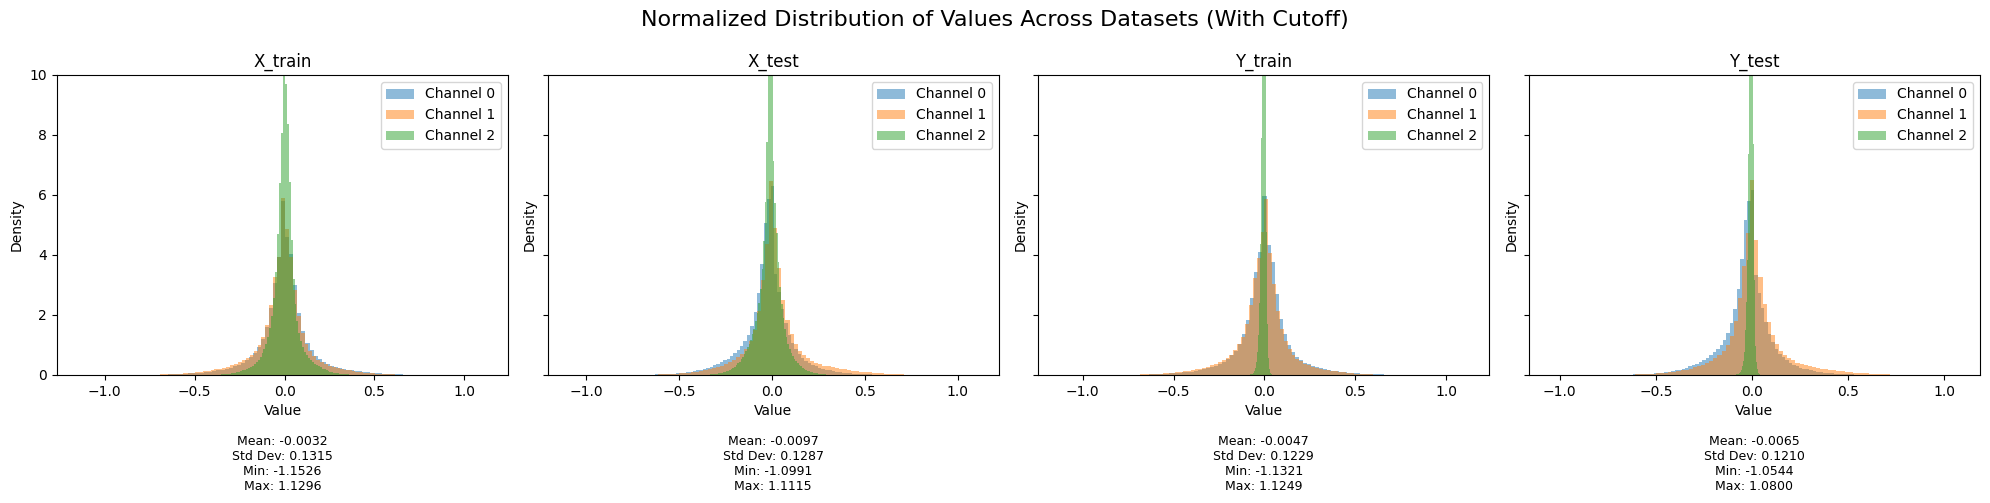

In [20]:
def analyze_data(X_train, X_test, Y_train, Y_test, bins=100, y_max=10):
    """
    Analyzes the distribution of values in the numpy arrays for training and testing.

    Parameters:
    - X_train, X_test, Y_train, Y_test: numpy arrays with shapes matching your data.
    - bins: Number of bins for histogram plotting.
    """
    def analyze_array(name, data, ax):
        mean_val = np.mean(data)
        std_val = np.std(data)
        min_val = np.min(data)
        max_val = np.max(data)
        summary = (f"Mean: {mean_val:.4f}\n"
                   f"Std Dev: {std_val:.4f}\n"
                   f"Min: {min_val:.4f}\n"
                   f"Max: {max_val:.4f}")

        #print(f"\n{name} Analysis:")
        #print(summary)

        for channel in range(data.shape[-1]):
            channel_data = data[..., channel].ravel()
            ax.hist(channel_data, bins=bins, alpha=0.5, density=True, label=f"Channel {channel}")
        
        ax.set_title(name)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
        ax.set_ylim(0, y_max)
        ax.text(0.5, -0.2, summary, transform=ax.transAxes, ha="center", va="top", fontsize=9)

    # Create subplots for horizontal alignment
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    fig.suptitle("Normalized Distribution of Values Across Datasets (With Cutoff)", fontsize=16)

    analyze_array("X_train", X_train, axes[0])
    analyze_array("X_test", X_test, axes[1])
    analyze_array("Y_train", Y_train, axes[2])
    analyze_array("Y_test", Y_test, axes[3])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.25)  # Adjust bottom for text space
    plt.show()

analyze_data(X_train, X_test, Y_train, Y_test)

## Step 2.1) Save/load as concatenated array

In [3]:
# # SAVE SPARSELY LOADED DATA TO SINGLE FILE:
# print("Saving compressed files out in shape.")
# np.savez_compressed("./data2D/loaded_data_v2.npz",
#                     X_train = X_train,
#                     Y_train = Y_train,
#                     X_test = X_test,
#                     Y_test = Y_test)

In [4]:
# start_time = time.perf_counter()
# combined_data_path = "./data2D/loaded_data_v2.npz"
# with np.load(combined_data_path) as data:
#     X_train = data["X_train"]
#     Y_train = data["Y_train"]
#     X_test  = data["X_test"]
#     Y_test  = data["Y_test"]
# end_time = time.perf_counter()
# print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")

In [5]:
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

Loaded X shape:  (1568, 111, 111, 3) (392, 111, 111, 3)
Loaded Y shape:  (1568, 111, 111, 3) (392, 111, 111, 3)


## Step 3) Difference and Randomize Data

In [6]:
# Calculate difference of Y layer
Y_train_orig = Y_train.copy()
Y_test_orig  = Y_test.copy()

Y_train2[:,:,0] = Y_train_orig[:,:,0] - X_train[:,:,1]
Y_train2[:,:,1] = Y_train_orig[:,:,1] - X_train[:,:,1]
Y_test2[:,:,0] = Y_test_orig[:,:,1] - X_test[:,:,0]
Y_test2[:,:,1] = Y_test_orig[:,:,1] - X_test[:,:,0]

for idx, Y in enumerate(Y_train_orig):
    Y_train[idx][:,:,0] = Y_train_orig[idx][:,:,0] - X_train[idx][:,:,0]  # X dim
    Y_train[idx][:,:,1] = Y_train_orig[idx][:,:,1] - X_train[idx][:,:,1]  # Y dim
for idx, Y in enumerate(Y_test_orig):
    Y_test[idx][:,:,0] = Y_test_orig[idx][:,:,0] - X_test[idx][:,:,0]  # X dim
    Y_test[idx][:,:,1] = Y_test_orig[idx][:,:,1] - X_test[idx][:,:,1]  # Y dim

del Y_train_orig
del Y_test_orig

NameError: name 'Y_train2' is not defined

In [ ]:
# Resize inputs to random slices and flip randomly
def randomize_crop_data_2d(input_data, n, seed=42):
    """Function to transform input to random slices of 64 voxels (in 2D)

    Args:
        input_data (List of np.array): list of training data
        n (int): number of variations, looping through input

    """
    tf.random.set_seed(seed)
    np.random.seed(seed)
    input_shape = input_data.shape
    
    output = []
    for i in range(n):
        index = i % input_shape[0]
        source_sample = input_data[index]

        # Randomly crop to desired size using TensorFlow
        random_sample = tf.image.random_crop(source_sample, size=(64, 64, 3))

        # Randomly flip along either x or y
        flip_rng = np.random.random()
        if flip_rng < 1/3:
            if flip_rng < 2/3: axis = 0
            else: axis = 1
            random_sample = tf.image.flip_left_right(random_sample) if axis == 1 else tf.image.flip_up_down(random_sample)

        # Randomly rotate by 90 degrees
        rot_rng = int(np.random.random() * 4)
        random_sample = tf.image.rot90(random_sample, k=rot_rng)

        # Convert the tensor to a NumPy array before appending to the output list
        output.append(random_sample.numpy())

    return output

print("X_train:     ", X_train.shape)
print("X_test:      ", X_test.shape)

ntrain = 5000
ntest = ntrain//5
X_train_rand = randomize_crop_data_2d(X_train, ntrain, seed=42)
Y_train_rand = randomize_crop_data_2d(Y_train, ntrain, seed=42)
X_test_rand  = randomize_crop_data_2d(X_test,  ntest,  seed=100)
Y_test_rand  = randomize_crop_data_2d(Y_test,  ntest,  seed=100)

print("X_train_rand: ", np.array(X_train_rand).shape)
print("X_test_rand:  ", np.array(X_test_rand).shape)

# 24-07-06 # BEWARE OF RANDOM SAMPLE FLIP AND ROTATE NOT WORKING

In [ ]:
def show_fields_array(array, value_scale=0.15, size=(10,20)):
    '''Visualize a 3d Array of [VelX, VelY, Pres]'''
    velx = array[:,:,0]
    vely = array[:,:,1]
    pres = array[:,:,2]
    #print("shape: ", velx.shape, vely.shape, pres.shape)
    fields = [velx, vely, pres]
    titles = ["vel.x", "vel.y", "pressure"]
    f = plt.figure( figsize=size )
    for idx, field in enumerate(fields):
        # Debug, plot figure
        f.add_subplot(1, 3, idx + 1)
        plt.title(titles[idx], loc='left')
        plt.imshow(field, vmin=-value_scale, vmax=value_scale)
    plt.show(block=True)
    print("Minmax (Velx, Vely, Pres): \t{}\t{}\t{}\t{}\t{}\t{}".format(round(velx.min(),2), round(velx.max(),2), round(vely.min(),2), round(vely.max(),2), round(pres.min(),2), round(pres.max(),2)))

# Visualize first instance of train test split
prev_idx = 10
print(f"\nTrain X and Y at idx {prev_idx}: ")
show_fields_array(X_train[prev_idx], value_scale=.15)
show_fields_array(Y_train[prev_idx], value_scale=.05)

for i in range(3):
    var = len(X_train)*i + prev_idx
    print(f"\n\nRandom Variation Nr. {i+1} of same ")
    show_fields_array(X_train_rand[var], value_scale=.25, size=(7.5,10))
    show_fields_array(Y_train_rand[var], value_scale=.1, size=(7.5,10))

## Step 3.1) Output randomized data

In [ ]:
# SAVE SPARSELY LOADED DATA TO SINGLE FILE:
print("Saving compressed files out in shape.")
start_time = time.perf_counter()
np.savez_compressed("./data2D/loaded_data_v2_rand.npz",
                    X_train = X_train_rand,
                    Y_train = Y_train_rand,
                    X_test = X_test_rand,
                    Y_test = Y_test_rand)
end_time = time.perf_counter()
print(f"Saved combined array in {end_time - start_time:.2f} seconds.")

In [ ]:
start_time = time.perf_counter()
combined_data_path = "./data2D/loaded_data_v2_rand.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]
end_time = time.perf_counter()
print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")